In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, classification_report, accuracy_score
import torch
from torch.utils.data import DataLoader, Dataset
from transformers import ViTFeatureExtractor, ViTForImageClassification, TrainingArguments, Trainer
from PIL import Image
import time

In [2]:
# Hyperparameters and Parameters
BATCH_SIZE = 16
IMAGE_SIZE = (224, 224)
EPOCHS = 40
LEARNING_RATE = 0.0001
WEIGHT_DECAY = 0.01
WARMUP_STEPS = 500
CLASS_MODE = 'categorical'

selected_classes = ['asteroid', 'black hole', 'comet', 'nebula', 'constellation']

In [3]:
# Define dataset paths
dataset_dir = "/kaggle/input/spacenet"
train_dir = os.path.join(dataset_dir, "train")
val_dir = os.path.join(dataset_dir, "val")
test_dir = os.path.join(dataset_dir, "test")

In [4]:
# Define the feature extractor
feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224')

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [5]:
# Custom dataset class for ViT
class CustomDataset(Dataset):
    def __init__(self, file_paths, labels, feature_extractor):
        self.file_paths = file_paths
        self.labels = labels
        self.feature_extractor = feature_extractor
        
    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        img_path = self.file_paths[idx]
        image = Image.open(img_path).convert("RGB")
        encoding = self.feature_extractor(images=image, return_tensors="pt")
        item = {key: val.squeeze(0) for key, val in encoding.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

In [6]:
def load_data(directory):
    file_paths = []
    labels = []
    for label in selected_classes:
        class_dir = os.path.join(directory, label)
        class_label = list(selected_classes).index(label)
        for file in os.listdir(class_dir):
            file_paths.append(os.path.join(class_dir, file))
            labels.append(class_label)
    return file_paths, labels

In [7]:
# Load the dataset
train_paths, train_labels = load_data(train_dir)
val_paths, val_labels = load_data(val_dir)
test_paths, test_labels = load_data(test_dir)

In [8]:
# Create datasets and dataloaders
train_dataset = CustomDataset(train_paths, train_labels, feature_extractor)
val_dataset = CustomDataset(val_paths, val_labels, feature_extractor)
test_dataset = CustomDataset(test_paths, test_labels, feature_extractor)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [9]:
# Load the ViT model
model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224', num_labels=len(selected_classes), ignore_mismatched_sizes=True)

config.json:   0%|          | 0.00/69.7k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([5]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([5, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [10]:
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=EPOCHS,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    warmup_steps=WARMUP_STEPS,
    learning_rate=LEARNING_RATE,
    weight_decay=WEIGHT_DECAY,
    logging_dir='./logs',
    logging_steps=10,
    evaluation_strategy="epoch",  # Evaluate after each epoch
    save_strategy="epoch",        # Save model after each epoch
    load_best_model_at_end=True,  # Load the best model found during training
    metric_for_best_model="eval_loss",  # Use eval_loss to determine the best model
    greater_is_better=False,      # Smaller validation loss is better
    save_total_limit=10,           # Only keep the last 10 models
    report_to="none"
)

/opt/conda/lib/python3.10/site-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [11]:
# Metrics
def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=1)
    precision = precision_score(labels, predictions, average='weighted')
    recall = recall_score(labels, predictions, average='weighted')
    f1 = f1_score(labels, predictions, average='weighted')
    accuracy = accuracy_score(labels, predictions)
    return {"accuracy": accuracy, "f1": f1, "precision": precision, "recall": recall}

In [12]:
# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)

In [13]:
# Measure start time
start_time = time.time()

# Train the model with the Trainer
history = trainer.train()

# Measure end time
end_time = time.time()
total_train_time = end_time - start_time

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.295100,0.343702,0.872861,0.872560,0.879071,0.872861
2,0.149500,0.544280,0.839853,0.837477,0.864470,0.839853
3,0.111400,0.286485,0.902200,0.902450,0.904046,0.902200
4,0.106900,0.395968,0.902200,0.902246,0.908991,0.902200
5,0.088100,0.296312,0.898533,0.897940,0.900457,0.898533
6,0.159100,0.442505,0.889976,0.889695,0.896339,0.889976
7,0.103500,0.460254,0.904645,0.903672,0.909385,0.904645
8,0.028100,0.428460,0.907090,0.906792,0.910300,0.907090
9,0.017400,0.355623,0.916870,0.916965,0.917186,0.916870
10,0.025600,0.359901,0.908313,0.908369,0.909110,0.908313


In [14]:
# Evaluate the model on the test set
eval_result = trainer.evaluate(test_dataset)
print('Test accuracy:', eval_result['eval_accuracy'])

Test accuracy: 0.9200968523002422


In [15]:
# Model parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
non_trainable_params = total_params - trainable_params
print('Total number of parameters:', total_params)
print('Number of trainable parameters:', trainable_params)
print('Number of non-trainable parameters:', non_trainable_params)

# Total train time
print('Total train time: {:.2f} seconds'.format(total_train_time))

Total number of parameters: 85802501
Number of trainable parameters: 85802501
Number of non-trainable parameters: 0
Total train time: 29597.21 seconds


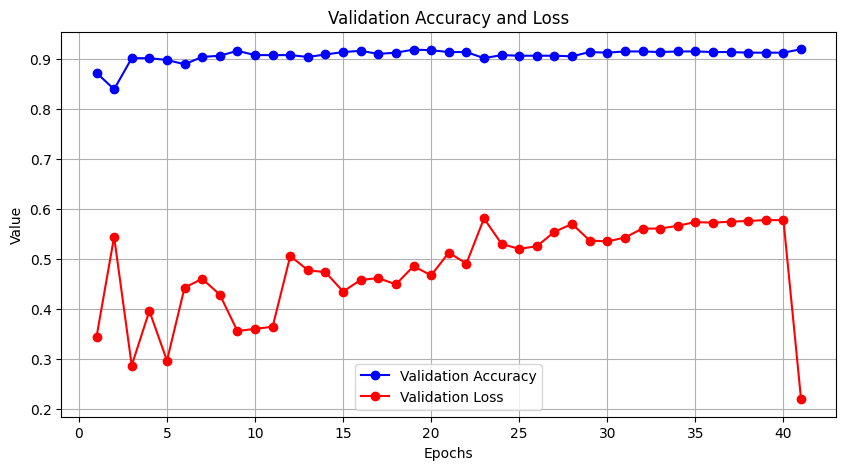

In [16]:
# Plot training & validation accuracy values
history = trainer.state.log_history

# Extracting validation accuracy and loss
val_accuracy = [h['eval_accuracy'] for h in history if 'eval_accuracy' in h]
val_loss = [h['eval_loss'] for h in history if 'eval_loss' in h]
epochs = range(1, len(val_accuracy) + 1)
plt.figure(figsize=(10, 5))
plt.plot(epochs, val_accuracy, 'bo-', label='Validation Accuracy')
plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
plt.title('Validation Accuracy and Loss')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

In [17]:
# Calculate model size in megabytes
model_size_mb = total_params * 4 / (1024 ** 2)  # Assuming float32
print(f'Model size: {model_size_mb:.2f} MB')

Model size: 327.31 MB


In [18]:
# Generate predictions using the test data
inference_start_time = time.time()
predictions = trainer.predict(test_dataset)
inference_end_time = time.time()

inference_time = inference_end_time - inference_start_time
print(f'Inference time: {inference_time:.2f} seconds')

Inference time: 74.68 seconds


In [19]:
y_pred = np.argmax(predictions.predictions, axis=1)
y_true = predictions.label_ids

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred)

In [20]:
# Sort classes by size
class_sizes = np.bincount(y_true)
sorted_indices = np.argsort(class_sizes)
sorted_cm = cm[sorted_indices, :][:, sorted_indices]
sorted_class_names = [selected_classes[i] for i in sorted_indices]

In [21]:
# Function to plot the confusion matrix with correct labels
def plot_confusion_matrix(cm, classes, figsize=(10, 8)):
    plt.figure(figsize=figsize)
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    # Calculate percentages row-wise and annotate the matrix
    for i in range(cm.shape[0]):
        row_sum = np.sum(cm[i, :])
        for j in range(cm.shape[1]):
            percentage = cm[i, j] / row_sum if row_sum > 0 else 0
            text = f'{cm[i, j]}\n({percentage:.2f})'
            plt.text(j, i, text,
                     ha='center', va='center',
                     color='white' if cm[i, j] > cm.max() / 2. else 'black')
    
    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

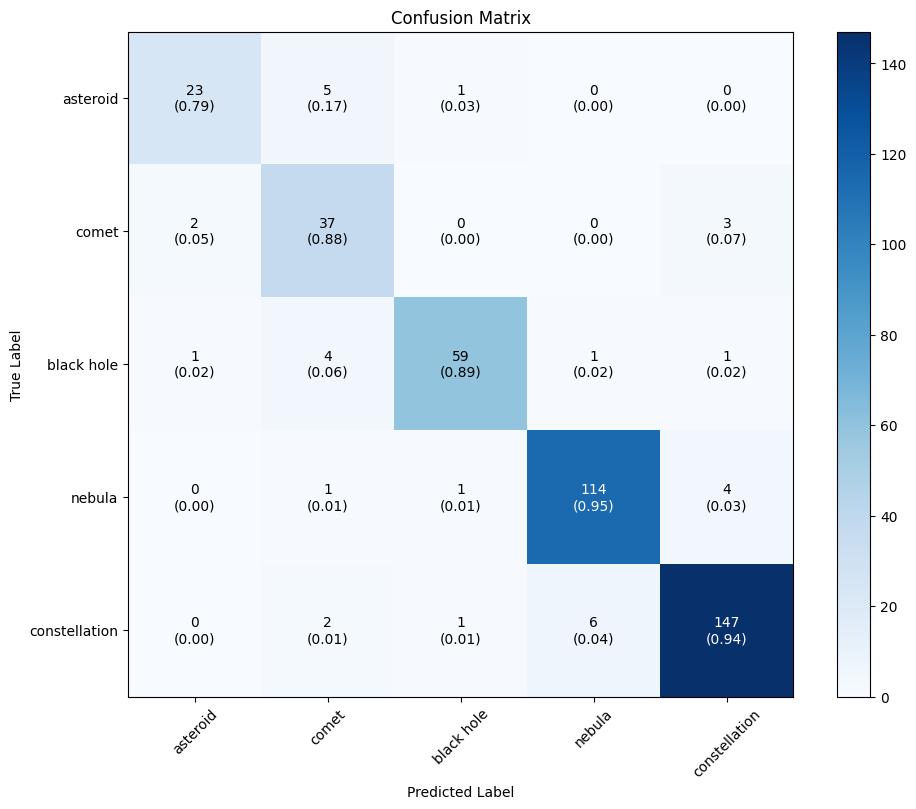

In [22]:
# Plot the confusion matrix with sorted labels
plot_confusion_matrix(sorted_cm, sorted_class_names)

In [23]:
# Calculate and print per-class metrics
for i, class_name in enumerate(sorted_class_names):
    class_precision = precision_score(y_true, y_pred, labels=[sorted_indices[i]], average='weighted')
    class_recall = recall_score(y_true, y_pred, labels=[sorted_indices[i]], average='weighted')
    class_f1 = f1_score(y_true, y_pred, labels=[sorted_indices[i]], average='weighted')
    class_accuracy = sorted_cm[i, i] / np.sum(sorted_cm[i, :]) if np.sum(sorted_cm[i, :]) > 0 else 0
    
    print(f'\nClass: {class_name}')
    print(f'Accuracy: {class_accuracy:.2f}')
    print(f'Precision: {class_precision:.2f}')
    print(f'Recall: {class_recall:.2f}')
    print(f'F1 Score: {class_f1:.2f}')


Class: asteroid
Accuracy: 0.79
Precision: 0.88
Recall: 0.79
F1 Score: 0.84

Class: comet
Accuracy: 0.88
Precision: 0.76
Recall: 0.88
F1 Score: 0.81

Class: black hole
Accuracy: 0.89
Precision: 0.95
Recall: 0.89
F1 Score: 0.92

Class: nebula
Accuracy: 0.95
Precision: 0.94
Recall: 0.95
F1 Score: 0.95

Class: constellation
Accuracy: 0.94
Precision: 0.95
Recall: 0.94
F1 Score: 0.95


In [24]:
# Calculate and print overall metrics
overall_precision = precision_score(y_true, y_pred, average='weighted')
overall_recall = recall_score(y_true, y_pred, average='weighted')
overall_f1 = f1_score(y_true, y_pred, average='weighted')

print(f'\nOverall Precision: {overall_precision:.2f}')
print(f'Overall Recall: {overall_recall:.2f}')
print(f'Overall F1 Score: {overall_f1:.2f}')


Overall Precision: 0.92
Overall Recall: 0.92
Overall F1 Score: 0.92
